In [1]:
import sys
import os
import os.path as op
# from dipy.io.image import load_nifti
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchio as tio
import numpy as np
# import pytorch_lightning as pl
import pandas as pd
import seaborn as sns
import re
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

/home/tim/anaconda3/envs/spinalseg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
data_path = op.join(sys.path[0], '../../Experiment4/sub-01/mfmri.nii.gz')

In [5]:
img = tio.ScalarImage(data_path)
img

ScalarImage(shape: (360, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/../../Experiment4/sub-01/mfmri.nii.gz")

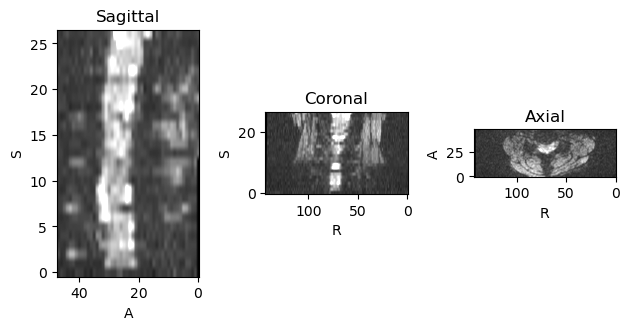

In [6]:
img.plot()

In [7]:
img.shape

(360, 144, 48, 27)

In [8]:
label_path = op.join(sys.path[0], '../../Experiment4/sub-01/mask_sc.nii.gz')

In [9]:
label = tio.LabelMap(label_path)
label

LabelMap(shape: (1, 144, 48, 27); spacing: (0.97, 0.97, 3.00); orientation: LAS+; path: "/home/tim/OneDrive/Studium M. Sc/EPFL/Project/dev/SpinalcordSeg/../../Experiment4/sub-01/mask_sc.nii.gz")

In [83]:
tio.ScalarImage(data_path).affine

array([[ -0.97222221,   0.        ,   0.        ,  70.00000763],
       [  0.        ,   0.91711758,   0.99564561, -54.52362823],
       [  0.        ,  -0.32266294,   2.82996287, -35.62229919],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [82]:
label.affine

array([[ -0.97222221,   0.        ,   0.        ,  70.00105286],
       [  0.        ,   0.91711758,   0.99564561, -54.52362823],
       [  0.        ,  -0.32266294,   2.82996287, -35.62229919],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

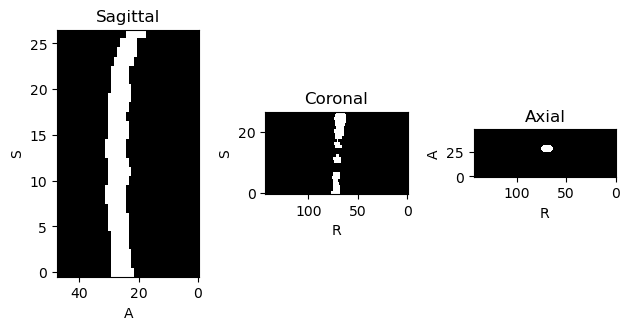

In [8]:
label.plot()

In [9]:
motion_param = {}
for i in range(1, 20):
    motion_param[f'sub{i}'] = pd.read_csv(f'../../Experiment4/sub-{i:02d}/motion_xy.txt', sep=" ", names=['x', 'y', 'remove'])[['x', 'y']]
    motion_param[f'sub{i}']['Volume'] = range(1,361)
    motion_param[f'sub{i}']['subject'] = f'sub{i}'
    
motion_param[f'sub21'] = pd.read_csv(f'../../Experiment4/sub-21/motion_xy.txt', sep=" ", names=['x', 'y', 'remove'])[['x', 'y']]

for i in motion_param.keys():
    motion_param[i]['Volume'] = range(1,361)
    motion_param[i]['subject'] = i

In [10]:
overall = pd.concat(motion_param.values())
overall

,x,y,Volume,subject
0,0.000000,0.000000,1,sub1
1,0.048104,0.133932,2,sub1
2,0.046358,0.186349,3,sub1
3,0.065004,0.247594,4,sub1
4,0.046905,0.077291,5,sub1
...,...,...,...,...
355,0.417137,0.879837,356,sub21
356,0.463591,0.582148,357,sub21
357,0.441066,0.778352,358,sub21
358,0.384013,0.891708,359,sub21


[Text(0.5, 0, 'subjects'),
 Text(0, 0.5, 'motion in y direction'),
 Text(0.5, 1.0, 'Motion in Y Direction')]

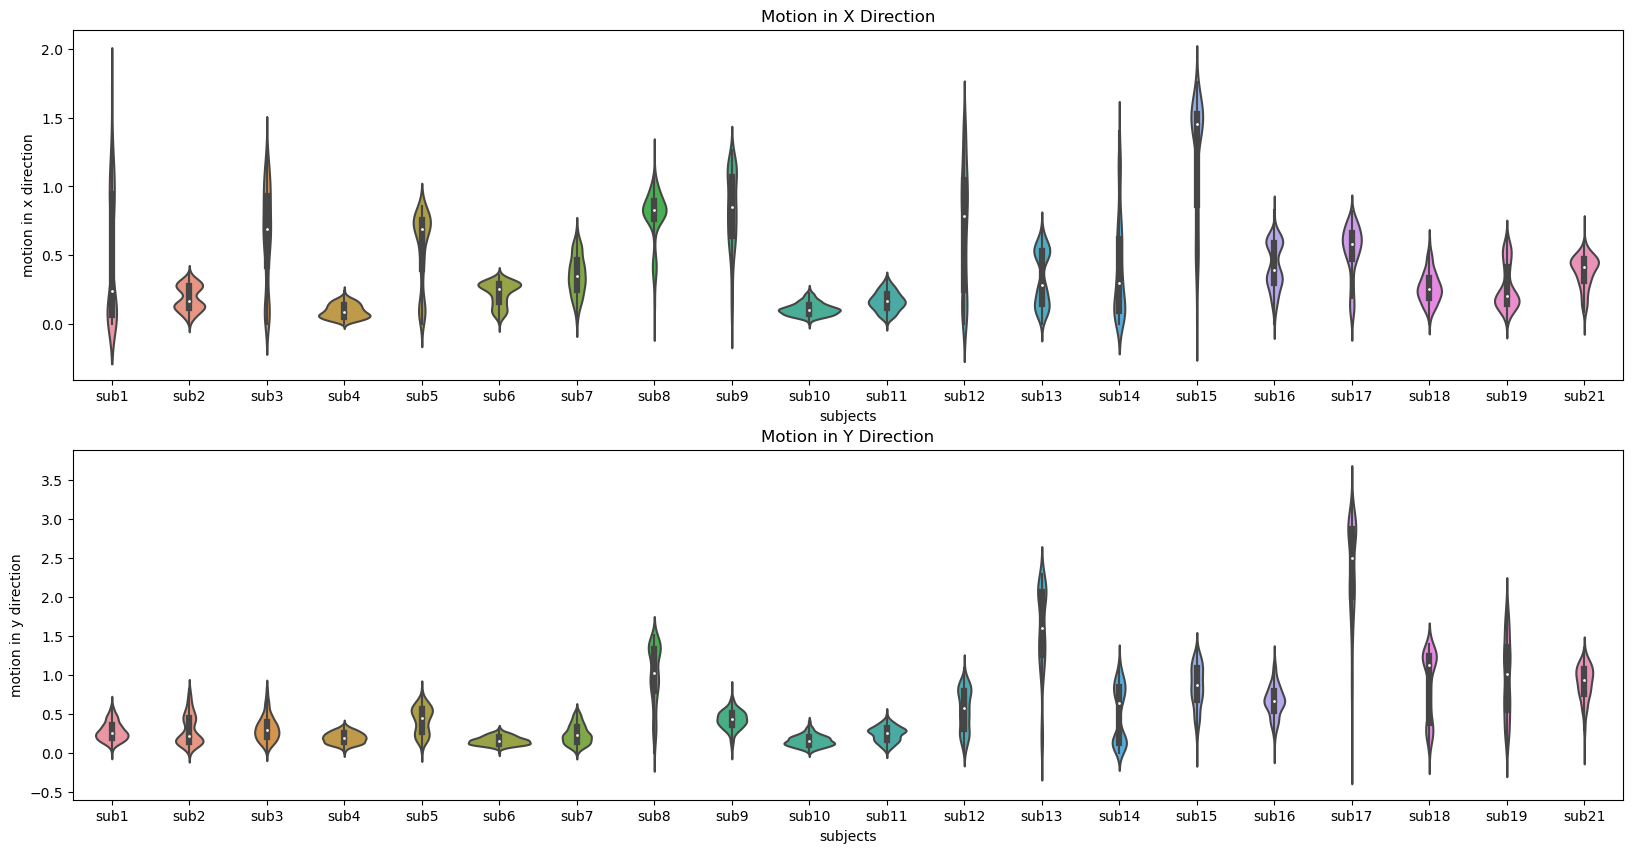

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
gx = sns.violinplot(data=overall, x='subject', y='x', ax=ax[0])
gx.set(xlabel='subjects', ylabel='motion in x direction', title='Motion in X Direction')

gy = sns.violinplot(data=overall, x='subject', y='y', ax=ax[1])
gy.set(xlabel='subjects', ylabel='motion in y direction', title='Motion in Y Direction')

[Text(0.5, 0, 'subjects'),
 Text(0, 0.5, 'motion in y direction'),
 Text(0.5, 1.0, 'Motion in Y Direction')]

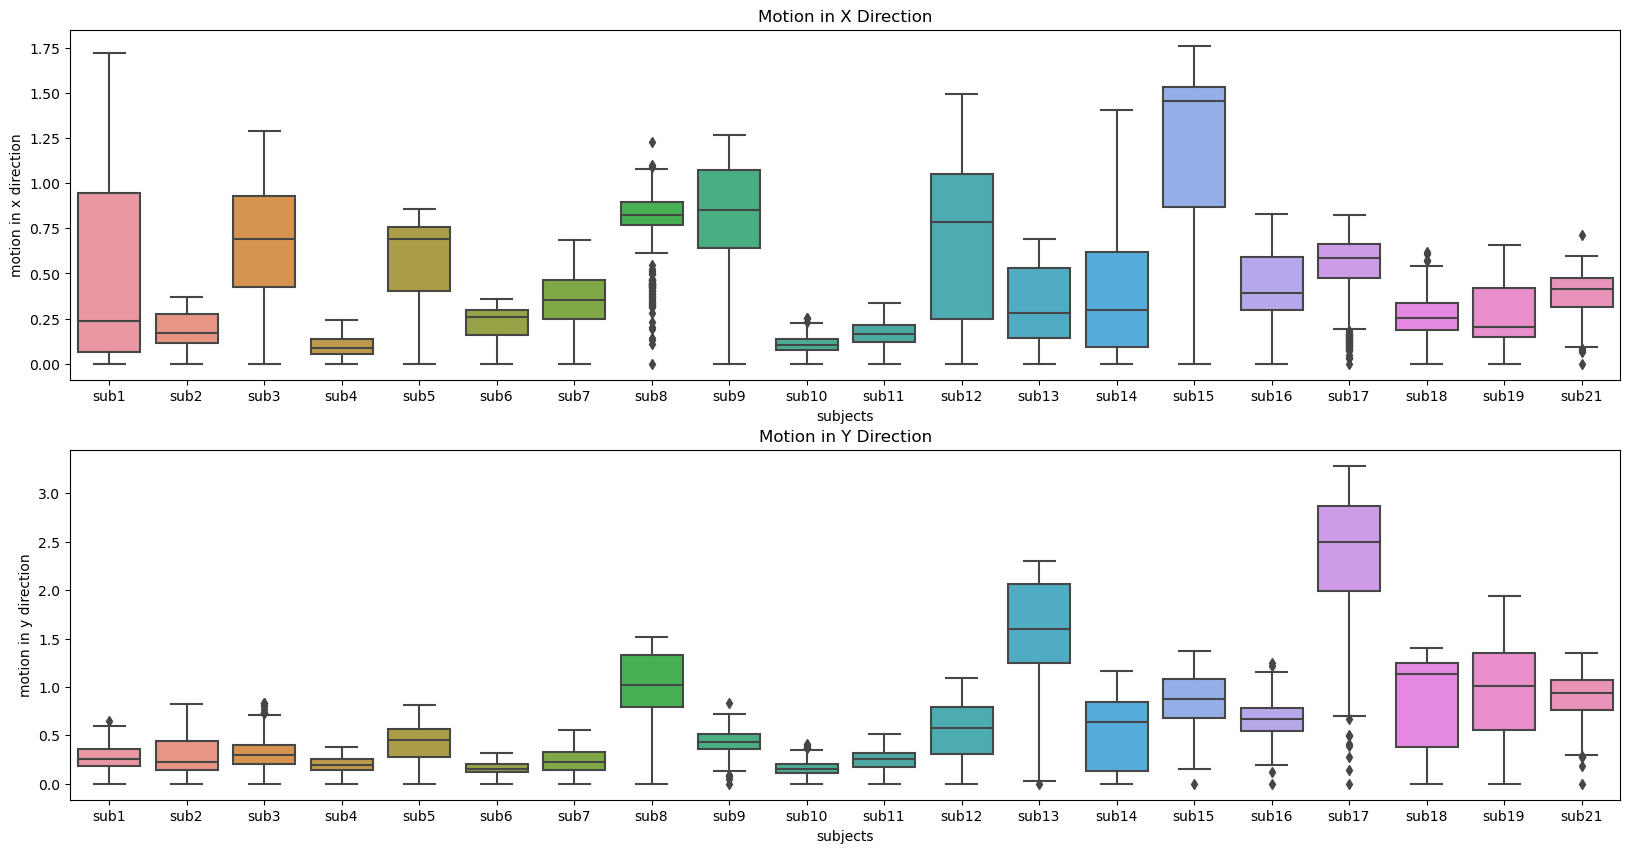

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
gx = sns.boxplot(data=overall, x='subject', y='x', ax=ax[0])
gx.set(xlabel='subjects', ylabel='motion in x direction', title='Motion in X Direction')

gy = sns.boxplot(data=overall, x='subject', y='y', ax=ax[1])
gy.set(xlabel='subjects', ylabel='motion in y direction', title='Motion in Y Direction')

Subjects with largest amplitude are: sub1, sub3, sub5, sub7, sub8, sub9, sub12, sub13, sub14, sub15, sub16, sub17, sub18, sub19, sub21

This leaves us with: sub2, sub4, sub6, sub10, sub11

In [13]:
mask = overall['subject'].isin(['sub2', 'sub4', 'sub6', 'sub10', 'sub11'])
filtered_overall = overall[mask]

Now calculating framewise displacement

In [14]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]
    trans_params = framewise_diff[['x', 'y']]
    fd = trans_params.abs().sum(axis=1)
    return fd

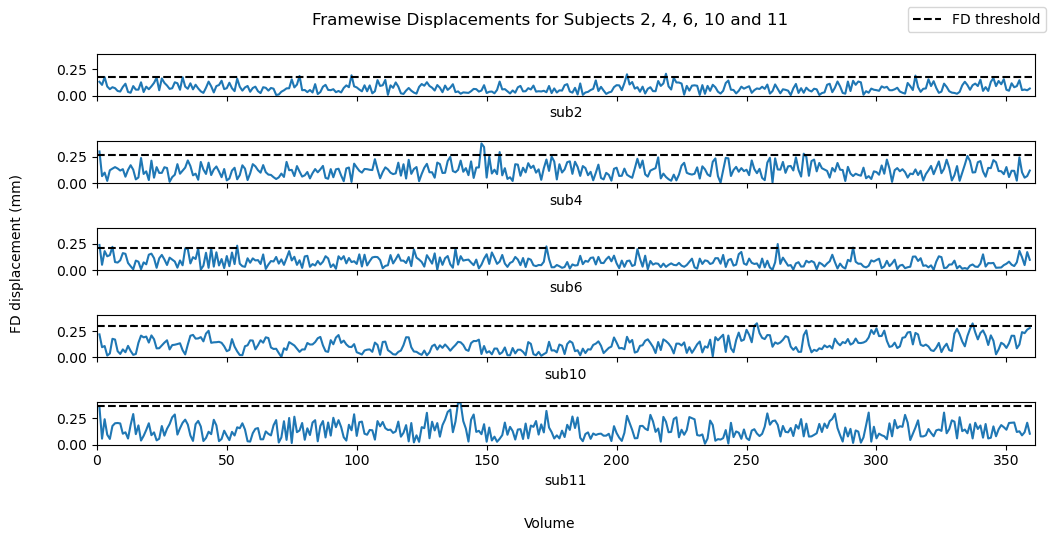

In [15]:
fig, ax = plt.subplots(filtered_overall['subject'].nunique(), 1, figsize=(10, 5), sharex=True)

for index, key in enumerate(filtered_overall['subject'].unique()):
    fd = compute_FD_power(filtered_overall[filtered_overall['subject'].isin([key])][['x', 'y']]).to_numpy()
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
    ax[index].plot(list(range(1, fd.size+1)), fd, label='_nolegend_')
    ax[index].set_xlim(left=0, right=361)
    ax[index].set_ylim(bottom=0, top=0.4)
    ax[index].hlines(threshold, 0, 360,colors='black', linestyles='dashed', label='FD threshold')
    ax[index].set_xlabel(key)

fig.text(0.5, -0.05, 'Volume', ha='center', rotation='horizontal')
fig.suptitle('Framewise Displacements for Subjects 2, 4, 6, 10 and 11')
fig.text(-0.04, 0.5, 'FD displacement (mm)', va='center', rotation='vertical')
fig.legend(['FD threshold'])
plt.tight_layout()

Maybe plotting the distribution of framewise displacements would be a more accurate solution. The chosen approach is however good enough.

In [16]:
for index, key in enumerate(filtered_overall['subject'].unique()):
    fd = compute_FD_power(filtered_overall[filtered_overall['subject'].isin([key])][['x', 'y']]).to_numpy()
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
    print(f'Motion Outliers for {key}:', np.where(fd > threshold)[0] + 1)
    print(f'Threshold for {key}: {threshold}')

Motion Outliers for sub2: [ 78  98 204 219 315]
Threshold for sub2: 0.17990999999999996
Motion Outliers for sub4: [  1 148 149 155 272]
Threshold for sub4: 0.26348375
Motion Outliers for sub6: [  1   6  54 173 262 291]
Threshold for sub6: 0.20878175000000002
Motion Outliers for sub10: [253 254 337]
Threshold for sub10: 0.29768675
Motion Outliers for sub11: [139 140]
Threshold for sub11: 0.3631835


Subject 2 will be chosen as the threshold is much lower. Setting the treshold to the one of subject 6 which is the second smallest, results in no 'outlier'.
We have a framewise displacement of 0.073562 +/- 0.039928 mm.

In [17]:
sub2_fd = compute_FD_power(filtered_overall[filtered_overall['subject'].isin(['sub2'])][['x', 'y']])
sub2_fd.describe()

count    359.000000
mean       0.073562
std        0.039928
min        0.006552
25%        0.043205
50%        0.067982
75%        0.097887
max        0.208611
dtype: float64

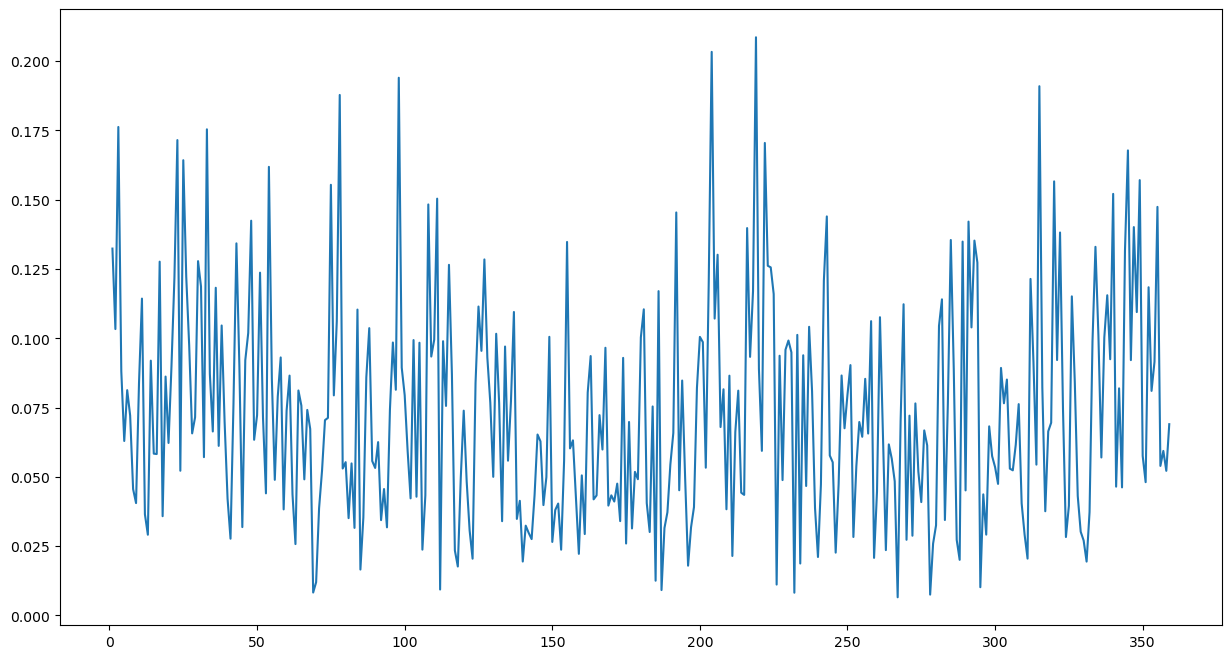

In [18]:
plt.figure(figsize=(15,8))
plt.plot(list(range(1, fd.size+1)), sub2_fd)

In [19]:
np.where(sub2_fd > 0.175)[0]

array([  2,  32,  77,  97, 203, 218, 314])

[Text(0.5, 0, 'subjects'),
 Text(0, 0.5, 'motion in y direction'),
 Text(0.5, 1.0, 'Motion in Y Direction')]

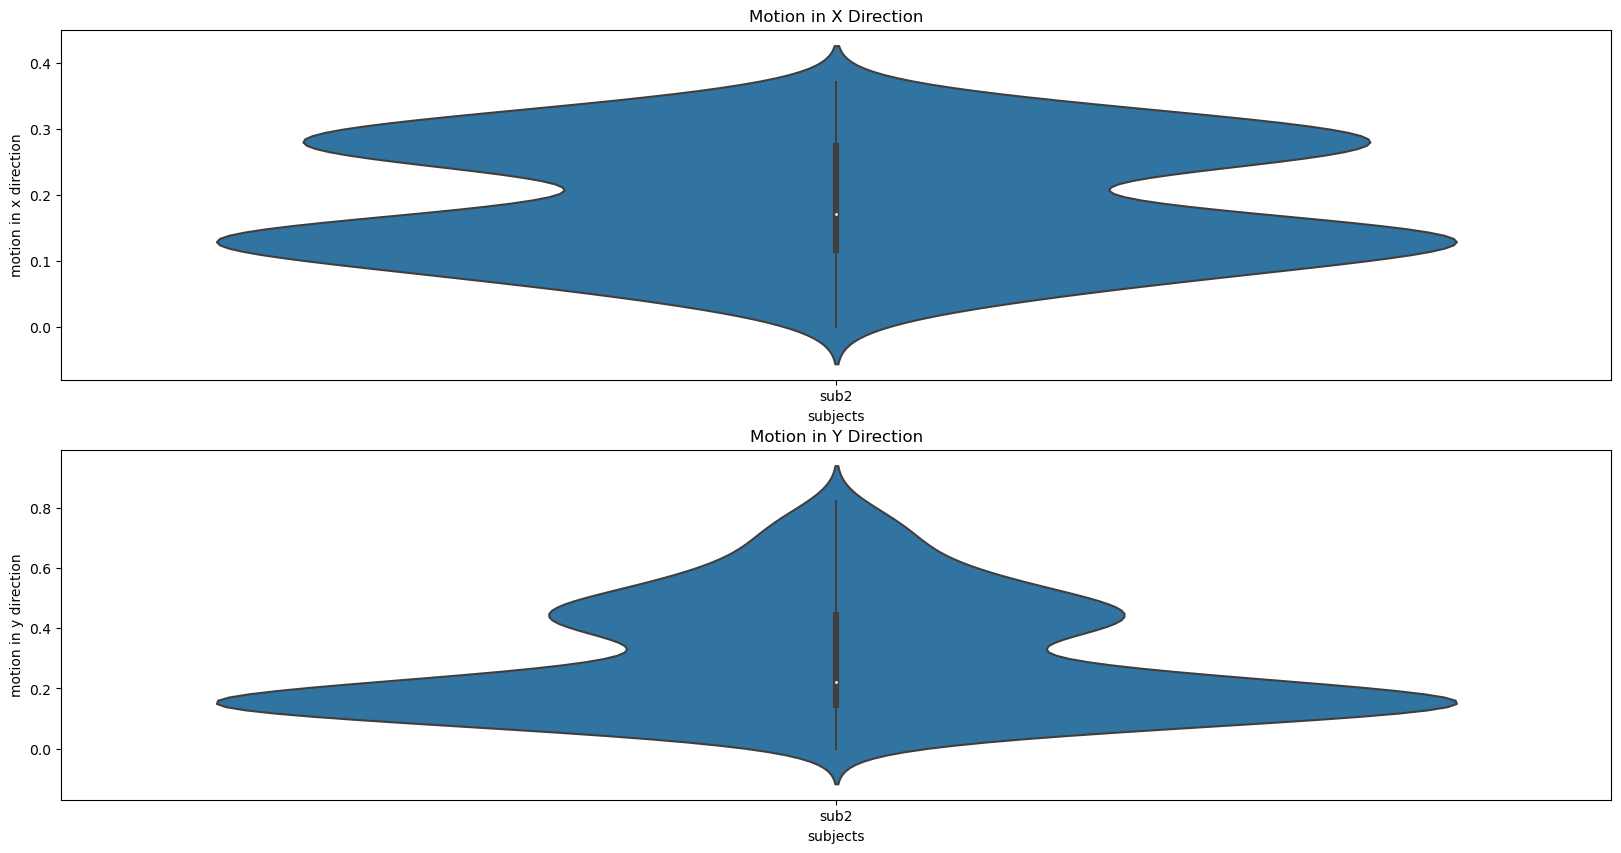

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
gx = sns.violinplot(data=filtered_overall[filtered_overall['subject'].isin(['sub2'])], x='subject', y='x', ax=ax[0])
gy = sns.violinplot(data=filtered_overall[filtered_overall['subject'].isin(['sub2'])], x='subject', y='y', ax=ax[1])
gx.set(xlabel='subjects', ylabel='motion in x direction', title='Motion in X Direction')
gy.set(xlabel='subjects', ylabel='motion in y direction', title='Motion in Y Direction')

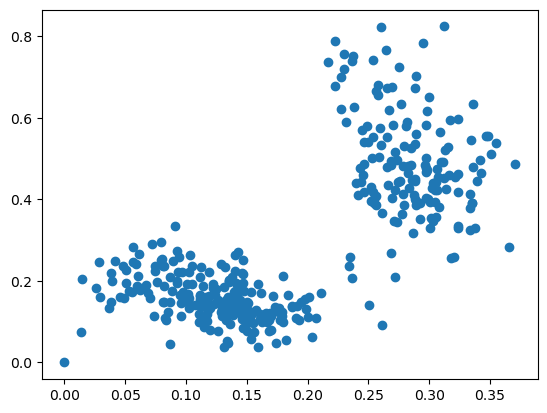

In [21]:
plt.scatter(filtered_overall[filtered_overall['subject'].isin(['sub2'])]['x'], filtered_overall[filtered_overall['subject'].isin(['sub2'])]['y'])

## Subject 2 prediction with SOTA model

### Splitting 4D sequence into 3D images

In [22]:
sub2 = op.join(sys.path[0], '../../Experiment4/sub-02/mfmri.nii.gz')

In [23]:
fmri_seq = tio.ScalarImage(sub2)

In [24]:
img_data = {}
for fmri_idx in range(fmri_seq.shape[0]):
    img_data[f'img{fmri_idx}'] = tio.ScalarImage(sub2)
    img_data[f'img{fmri_idx}'].set_data(fmri_seq.data[fmri_idx, :, :, :][None, :])
    img_data[f'img{fmri_idx}'].save(f'../../Experiment4/sub-02/single_images/fmri-{fmri_idx}.nii.gz')

In [2]:
from torchio.transforms.transform import Transform
from torchio.utils import get_subclasses
from torchio.transforms.augmentation.composition import Compose

In [185]:
from torch.utils.data import Dataset
import random

random.seed(42)

class SpinalCordDataset(Dataset):
    def __init__(self, annotations_files, img_files, transform=None, target_transform=None):
        self.img_labels = annotations_files
        self.img_files = img_files
        self.transform = transform
        self.target_transform = target_transform
        self.history_transforms = {}
        for idx in range(len(self.img_files)):
            self.history_transforms[idx] = self.transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        image = img_file#.data
        label = self.img_labels[idx].data
        if self.transform:
            image = self.history_transforms[idx](image)#.reshape(1,160,-1)
        if self.target_transform:
            label = self.target_transform(label).reshape(1,160,-1)
        return image, label
    
#     def get_applied_transforms(self):
#         name_to_transform = {
#             cls.__name__: cls
#             for cls in get_subclasses(Transform)
#         }
#         transforms_list = []
#         for transform_name, arguments in self.transform:
#             transform = name_to_transform[transform_name](**arguments)
#             transforms_list.append(transform)
#         return transforms_list
    
#     def get_composed_history(self):
#         transforms = self.get_applied_transforms()
#         return Compose(transforms)
    
#     def get_inverse_transform(self, warn: bool=True) -> Compose:
#         history_transform = self.get_composed_history()
#         inverse_transform = history_transform.inverse(warn=warn)
#         return inverse_transform
    
#     def _get_reproducing_arguments(self):
#         """
#         Return a dictionary with the arguments that would be necessary to
#         reproduce the transform exactly.
#         """
#         reproducing_arguments = {
#             'include': self.include,
#             'exclude': self.exclude,
#             'copy': self.copy,
#         }
#         args_names = {name: getattr(self, name) for name in self.args_names}
#         reproducing_arguments.update(args_names)
#         return reproducing_arguments

In [218]:
image_files = []
image_labels = []

single_imgs = Path(op.join(sys.path[0], '../../Experiment4/sub-02/single_images'))

for file in single_imgs.iterdir():
    image_files.append(tio.ScalarImage(file))

# get index of the fmri volume and add the corresponding mask in the same order
regex = re.compile(r'\d+')
for img in image_files:
    idx = [int(x) for x in regex.findall(str(img.path))][2]
    if idx in [0, 2, 3, 225]:
        label_path = op.join(sys.path[0], f'../../Experiment4/sub-02/mask_sc_vol{idx}.nii.gz')
    else:
        label_path = op.join(sys.path[0], '../../Experiment4/sub-02/mask_sc.nii.gz')
    image_labels.append(tio.LabelMap(label_path))

In [219]:
dataset = SpinalCordDataset(image_labels, image_files, tio.CropOrPad((160, 64, 35)), tio.CropOrPad((160, 64, 35)))

In [220]:
dataset[0][0].apply_inverse_transform

AttributeError: 'ScalarImage' object has no attribute 'apply_inverse_transform'

Load the trained model

In [3]:
import segmentation_models_pytorch.utils as smpu
# test_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [4]:

loss = smpu.losses.DiceLoss()
metrics = [
    smpu.metrics.IoU(threshold=0.5),
]
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
created_model = torch.load('../../output3/k_cross.pth')

In [150]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 23/23 [08:51<00:00, 23.09s/it, dice_loss - 0.09877, iou_score - 0


In [5]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(np.swapaxes(image, 0, 1))
    plt.show()

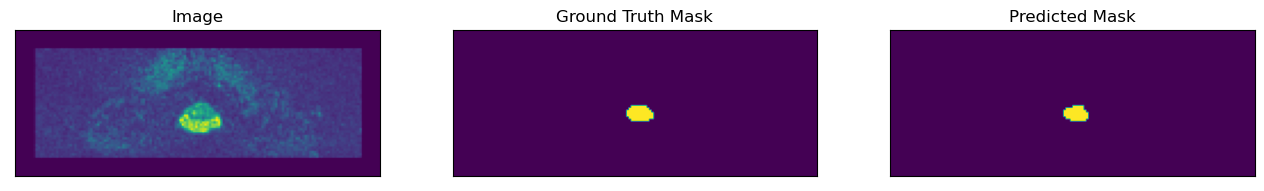

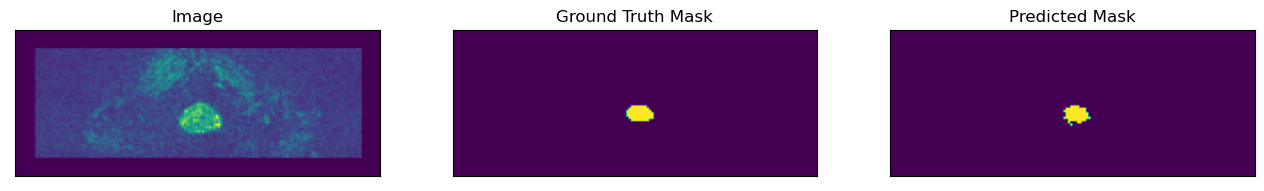

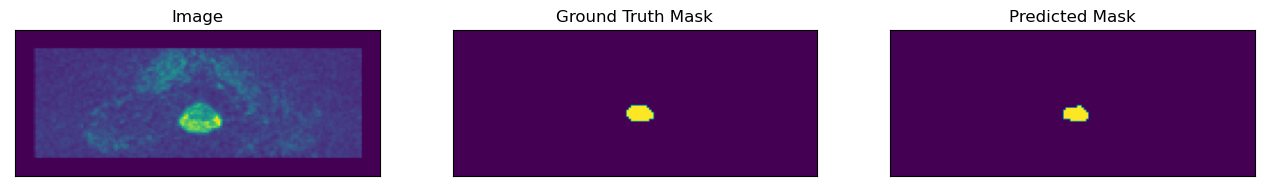

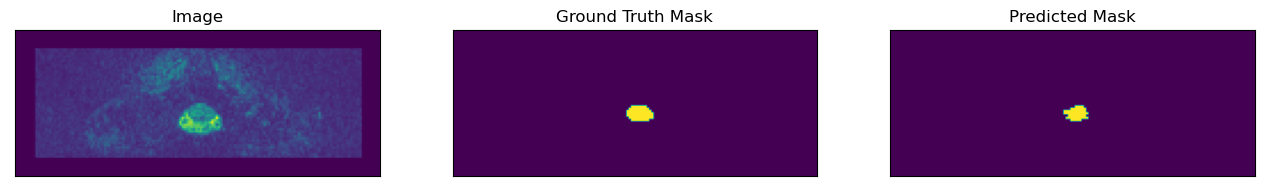

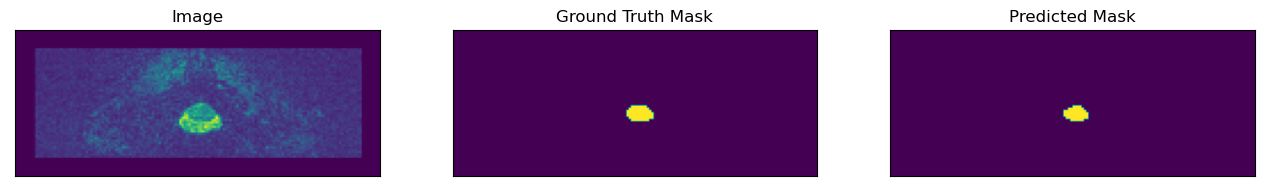

In [31]:
for i in range(5):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(160, 64, 35)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(160,64,35)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = created_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round()).reshape(160,64,35)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [32]:
1-logs['dice_loss']

NameError: name 'logs' is not defined

In [160]:
logs

{'dice_loss': 0.0987721085548401, 'iou_score': 0.8229122213695359}

## Each image as different subject

In [6]:
subjects = []

In [8]:
single_imgs = Path(op.join(sys.path[0], 'dataset/Experiment4/sub-02/single_images'))
regex = re.compile(r'\d+')

for file in single_imgs.iterdir():
    idx = int(regex.findall(str(file))[2])
    if idx in [0, 2, 3, 225]:
        label_path = op.join(sys.path[0], f'dataset/Experiment4/sub-02/mask_sc_vol{idx}.nii.gz')
    else:
        label_path = op.join(sys.path[0], 'dataset/Experiment4/sub-02/mask_sc.nii.gz')
        
    subjects.append(tio.Subject(img=tio.ScalarImage(file), label=tio.LabelMap(label_path),
                                num=idx, shape=[tio.ScalarImage(file).shape]))

In [159]:
dataset = tio.SubjectsDataset(subjects, transform=tio.CropOrPad((160, 64, 35)))

In [204]:
test = dataset[0]

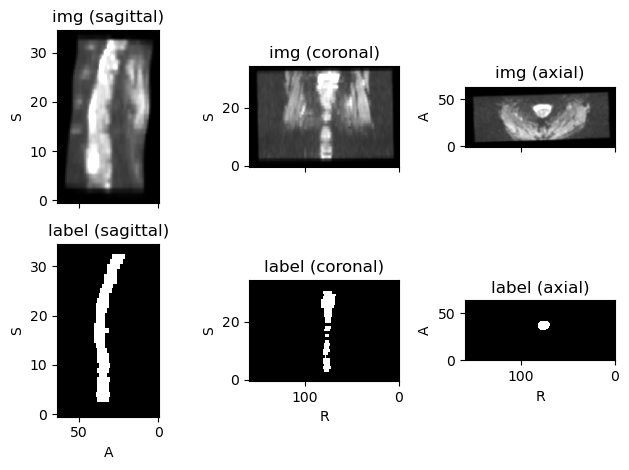

In [205]:
test.plot()

In [206]:
test.history

[Pad(padding=(8, 8, 8, 8, 3, 2), padding_mode=0),
 Affine(scales=(1.0, 1.0, 1.0), degrees=(0.9977831840515137, 0.14551663398742676, -1.6699554920196533), translation=(0.0, 0.0, 0.0), center=image, default_pad_value=minimum, image_interpolation=linear, label_interpolation=nearest, check_shape=True),
 Affine(scales=(1.0, 1.0, 1.0), degrees=(2.6262152194976807, 0.12157988548278809, -0.4482557773590088), translation=(-0.572896420955658, -0.6342151761054993, 0.0), center=image, default_pad_value=minimum, image_interpolation=linear, label_interpolation=nearest, check_shape=True),
 ElasticDeformation(control_points=[[[[ 0.          0.          0.        ]
    [ 0.          0.          0.        ]
    [ 0.          0.          0.        ]
    ...
    [ 0.          0.          0.        ]
    [ 0.          0.          0.        ]
    [ 0.          0.          0.        ]]
 
   [[ 0.          0.          0.        ]
    [ 0.          0.          0.        ]
    [ 0.          0.          0.      

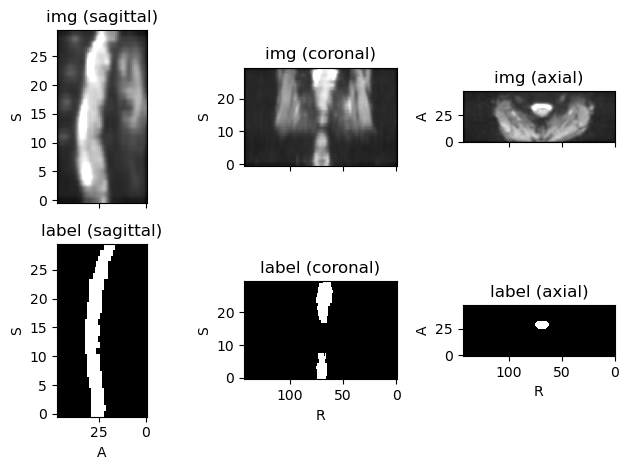

In [207]:
test.get_inverse_transform()(test).plot()

## Augmentation

New split of data needed to have test and training data

In [36]:
dataset

In [37]:
# split into 60 / 20 / 20
set_split = 0.2
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(set_split * dataset_size))
train_indices, val_indices, test_indices = indices[split*2:], indices[split:split*2], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

Senseful transformations for fMRI imaging:
- elastic deformation
- lateral flipping
- affine transformations
- scaling

In [38]:
scaling = tio.transforms.RandomAffine(scales=(1, 1.5), degrees=(0, 0), center='image', isotropic=True)

In [174]:
test = dataset[0]
test = test.img

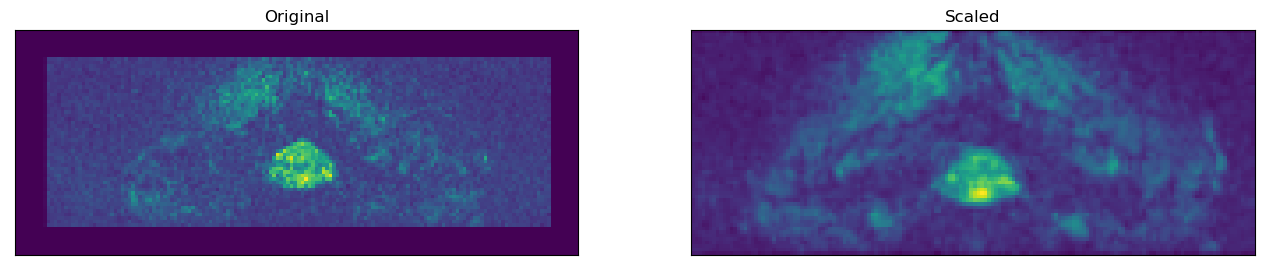

In [40]:
visualize(original=test.data[0,:,:,12], scaled=scaling(test).data[0,:,:,12])

In [41]:
lateral = tio.transforms.RandomAffine(scales=(1, 1), degrees=(-5, 5), translation=0, center='image')
affine = tio.transforms.RandomAffine(scales=(1, 1), degrees=(-5, 5),
                                     translation=(1.5, 2.5, 0), center='image')

In [42]:
transform = tio.CropOrPad((160,64,35))
# test = dataset[0][0]
lateral(transform(test))

ScalarImage(shape: (1, 160, 64, 35); spacing: (0.97, 0.97, 3.00); orientation: LAS+; dtype: torch.FloatTensor; memory: 1.4 MiB)

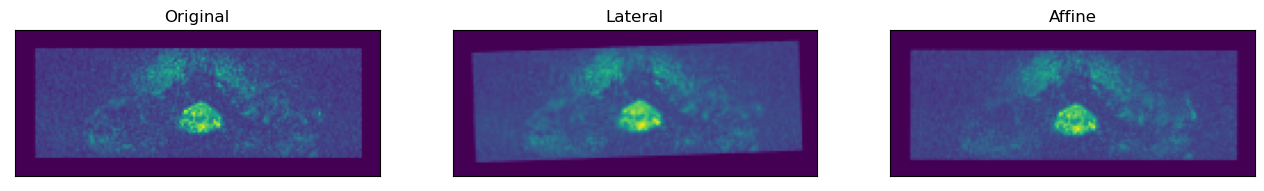

In [43]:
visualize(original=test.data[0,:,:,12], lateral=lateral(test).data[0,:,:,12], affine=affine(test).data[0,:,:,12])

In [44]:
elastic = tio.transforms.RandomElasticDeformation(num_control_points=7, max_displacement=3.5, locked_borders=2,
                                                  image_interpolation='linear',
                                                  label_interpolation='nearest')
elastic1 = tio.transforms.RandomElasticDeformation(num_control_points=6, max_displacement=3.5, locked_borders=2,
                                                  image_interpolation='linear',
                                                  label_interpolation='nearest')
elastic2 = tio.transforms.RandomElasticDeformation(num_control_points=5, max_displacement=3.5, locked_borders=2,
                                                  image_interpolation='linear',
                                                  label_interpolation='nearest')
elastic3 = tio.transforms.RandomElasticDeformation(num_control_points=8, max_displacement=3.5, locked_borders=2,
                                                  image_interpolation='linear',
                                                  label_interpolation='nearest')

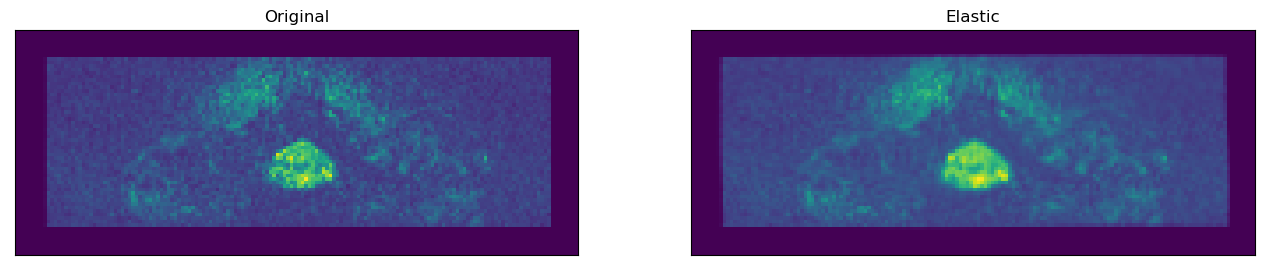

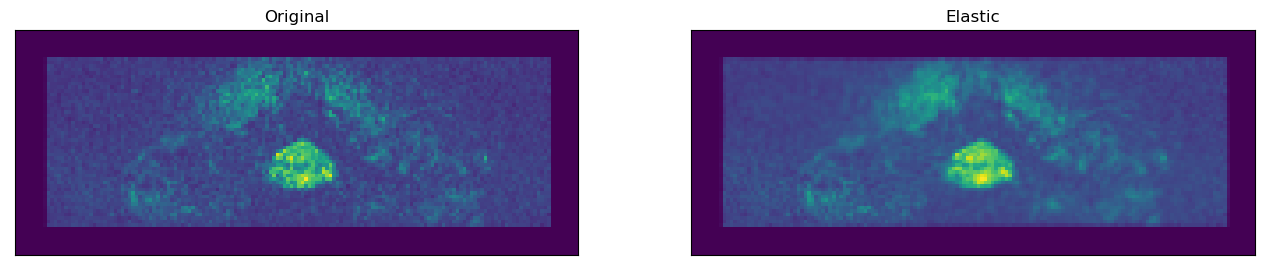

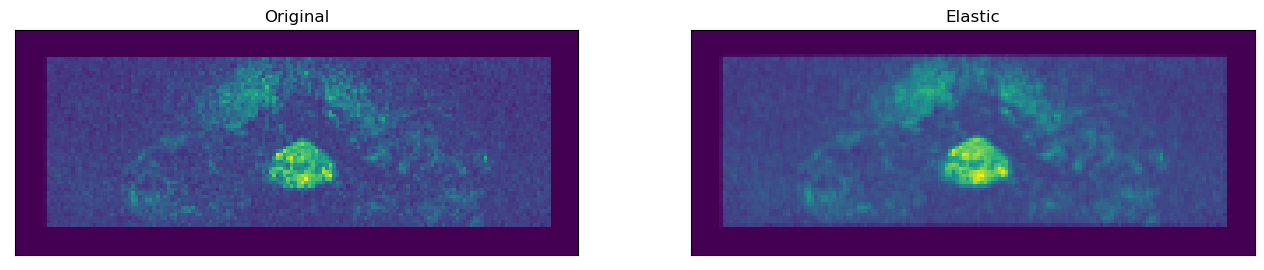

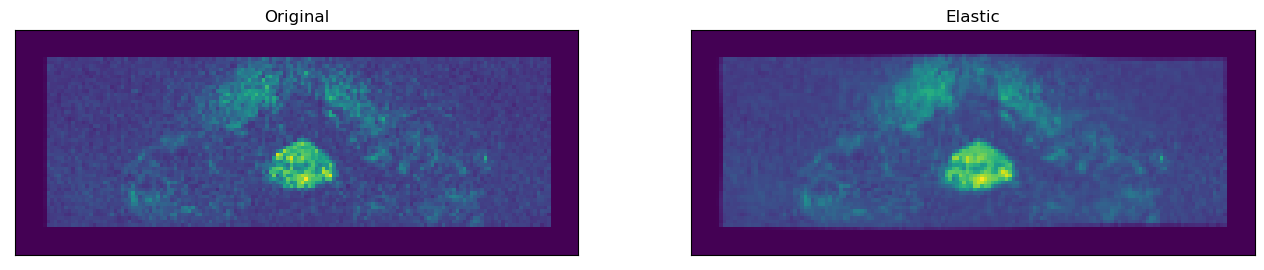

In [45]:
visualize(original=test.data[0,:,:,12], elastic=elastic(test).data[0,:,:,12])
visualize(original=test.data[0,:,:,12], elastic=elastic1(test).data[0,:,:,12])
visualize(original=test.data[0,:,:,12], elastic=elastic2(test).data[0,:,:,12])
visualize(original=test.data[0,:,:,12], elastic=elastic3(test).data[0,:,:,12])

In the axial image the spinal cord shouldn't be deformed that much as the form of the spine should stay the same. Only the crook should differ.

In [46]:
elastic = tio.transforms.RandomElasticDeformation(num_control_points=(5, 9, 9),
                                                  max_displacement=(1.5, 4.5, 4.5),
                                                  locked_borders=2,
                                                  image_interpolation='linear',
                                                  label_interpolation='nearest')

In [9]:
def new_visualize(*images):
    for i, image in enumerate(images):
        image.plot()

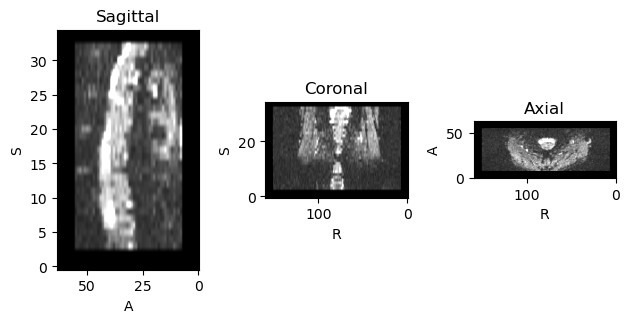

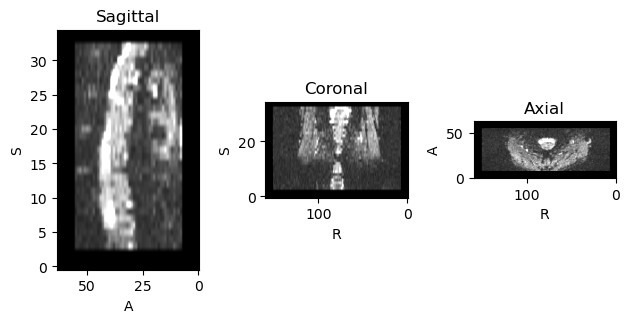

In [178]:
new_visualize(none(test), test)

chosen parameters for augmentation:

In [10]:
lateral = tio.transforms.RandomAffine(scales=(1, 1), degrees=(-3, 3), translation=0, center='image',
                                      include='img')
affine = tio.transforms.RandomAffine(scales=(1, 1), degrees=(-3, 3),
                                     translation=(1.5, 2.5, 0), center='image', include='img')
scaling = tio.transforms.RandomAffine(scales=(1, 1.5), degrees=(0, 0), center='image', isotropic=True,
                                      include='img')
elastic = tio.transforms.RandomElasticDeformation(num_control_points=(5, 10, 10),
                                                  max_displacement=(1.5, 4.5, 4.5),
                                                  locked_borders=2,
                                                  image_interpolation='linear',
                                                  label_interpolation='nearest',
                                                 include='img')
pad = tio.CropOrPad((160, 64, 35), include='img')
lateral = tio.transforms.Compose([pad, lateral])
affine = tio.transforms.Compose([pad, affine])
scaling = tio.transforms.Compose([pad, scaling])
elastic = tio.transforms.Compose([pad, elastic])

Composition and probability of the transformations:

In [11]:
trans1 = tio.transforms.Compose([pad, lateral, affine])
trans2 = tio.transforms.Compose([pad, lateral, scaling])
trans3 = tio.transforms.Compose([pad, affine, scaling])
trans4 = tio.transforms.Compose([pad, lateral, affine, scaling])
trans5 = tio.transforms.Compose([pad, lateral, elastic])
trans6 = tio.transforms.Compose([pad, affine, elastic])
trans7 = tio.transforms.Compose([pad, scaling, elastic])
trans8 = tio.transforms.Compose([pad, lateral, affine, elastic])
trans9 = tio.transforms.Compose([pad, lateral, scaling, elastic])
trans10 = tio.transforms.Compose([pad, affine, scaling, elastic])
trans11 = tio.transforms.Compose([pad, lateral, affine, scaling, elastic])

In [12]:
transforms_dict = {
    trans1: 1,
    trans2: 1,
    trans3: 1,
    trans4: 1,
    trans5: 1,
    trans6: 1,
    trans7: 1,
    trans8: 1,
    trans9: 1,
    trans10: 1,
    trans11: 1,
    lateral: 1,
    affine: 1,
    scaling: 1,
    elastic: 1,
    pad: 15 # don't transform all data
} 
all_transforms = tio.OneOf(transforms_dict)

## Apply Augmentation, predict and inverse transformation

In [13]:
new_dataset = tio.SubjectsDataset(subjects, transform=all_transforms)

In [198]:
new_dataset[0]['img']

ScalarImage(shape: (1, 144, 48, 30); spacing: (0.97, 0.97, 3.00); orientation: LAS+; dtype: torch.FloatTensor; memory: 810.0 KiB)

In [147]:
new_dataset[0].get_inverse_transform

<bound method Subject.get_inverse_transform of Subject(Keys: ('img', 'label', 'num', 'shape'); images: 2)>

In [15]:
# split into 60 / 20 / 20
set_split = 0.2
dataset_size = len(new_dataset)
indices = list(range(dataset_size))
split = int(np.floor(set_split * dataset_size))
train_indices, val_indices, test_indices = indices[split*2:], indices[split:split*2], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [16]:
train_loader = DataLoader(new_dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(new_dataset, batch_size=16, sampler=valid_sampler)
test_loader = DataLoader(new_dataset, batch_size=16, sampler=test_sampler)

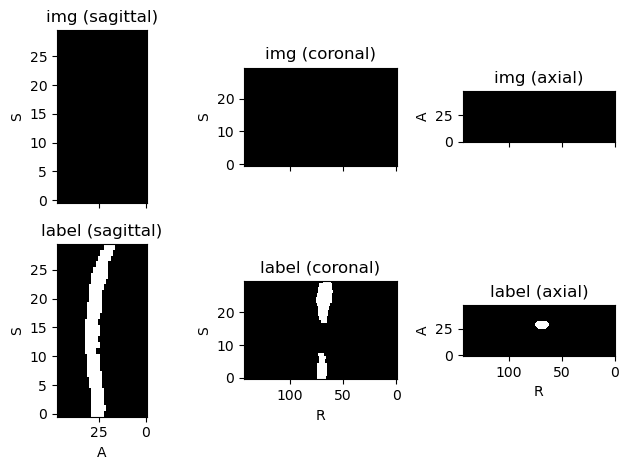

In [190]:
sample = new_dataset[0]
sample.plot()

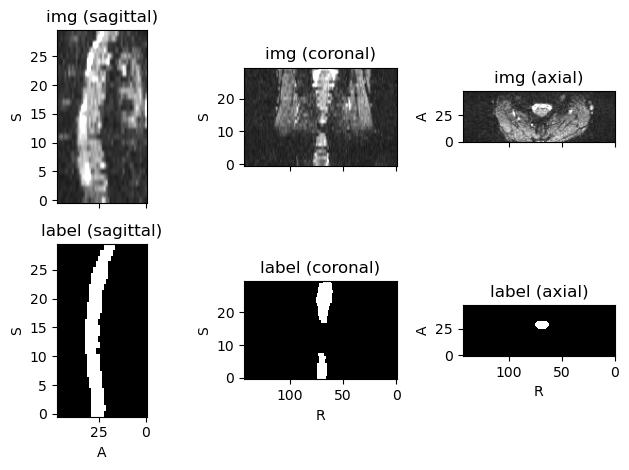

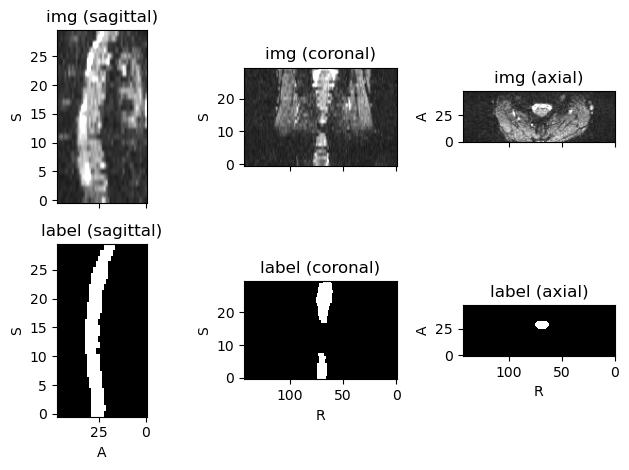

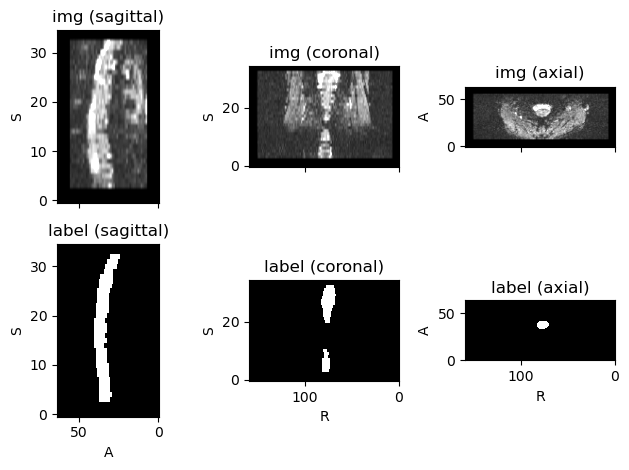

In [189]:
for i in subjects:
    if i.num == sample.num:
        i.plot()

In [152]:
test_epoch = ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid:   0%|                                              | 0/5 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
class NewValidEpoch(smpu.train.ValidEpoch):
    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            
            loss = self.loss(prediction, y)
        return loss, prediction

## FSLeyes

In [9]:
load('../../Experiment4/sub-01/mfmri.nii.gz')

Image(mfmri, /home/tim/OneDrive/Studium M. Sc/EPFL/Project/Experiment4/sub-01/mfmri.nii.gz)

In [10]:
load('../../Experiment4/sub-01/mask_sc.nii.gz')

Image(mask_sc, /home/tim/OneDrive/Studium M. Sc/EPFL/Project/Experiment4/sub-01/mask_sc.nii.gz)

## Mask Creation


In [4]:
transform1 = tio.CropOrPad((160, 64, 35))
img = transform1(img.data[0][None,:])

In [74]:
x_tensor = img.reshape(1,160,-1).to(DEVICE).unsqueeze(0)
pr_mask = created_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round()).reshape(160,64,35)

In [91]:
new_mask = tio.ScalarImage(data_path)
new_mask.set_data(pr_mask[None,:])
new_mask.save('test.nii.gz')

In [5]:
tio.ScalarImage('test.nii.gz').plot()

FileNotFoundError: File not found: "test.nii.gz"

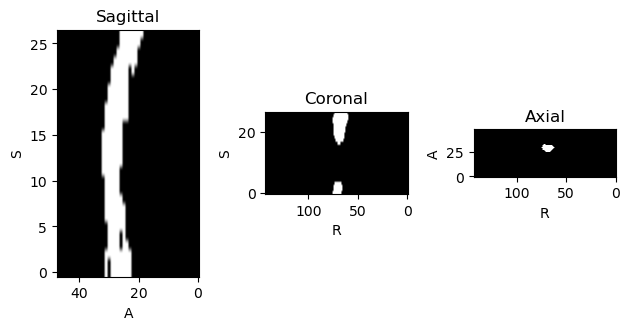

In [101]:
tio.ScalarImage('test2.nii.gz').plot()

In [94]:
tio.ScalarImage(data_path).shape

(360, 144, 48, 27)

In [95]:
reverse_trans = tio.CropOrPad((144, 48, 27))

In [98]:
new_mask = reverse_trans(new_mask)
new_mask.save('test2.nii.gz')

## Rewrite util.train.py

In [8]:
def inverse_trans(subjects_num):
    inverse_trans = []
    for i in subjects_num:
        inverse_trans.append(new_dataset[i].get_inverse_transform())
    return inverse_trans

In [9]:
import sys
import torch
from tqdm import tqdm as tqdm
from segmentation_models_pytorch.utils.meter import AverageValueMeter


class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for data in iterator:
                x = data['img']['data']
                y = data['label']['data']
                z = inverse_trans(data['num'])

                x, y = x.to(self.device), y.to(self.device)

                loss, y_pred = self.batch_update(x, y, z)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y, z):
        batch_size = x.shape[0]
        o_shape = x.shape
        x = x.reshape(batch_size, 1, 160, -1)
        inverse = z
        
        self.optimizer.zero_grad()
        prediction = self.model.forward(x).reshape(o_shape)
        
        loss = 0
        for i in range(batch_size):
            loss += self.loss(inverse[i](prediction[i, :, :, :, :]), inverse[i](y[i, :, :, :, :]))
            
        loss = loss / batch_size
        
#         loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y, z):
        batch_size = x.shape[0]
        o_shape = x.shape
        x = x.reshape(batch_size, 1, 160, -1)
        inverse = z
        
        with torch.no_grad():
            prediction = self.model.forward(x).reshape(o_shape)
            
            loss = 0
            for i in range(batch_size):
                loss += self.loss(inverse[i](prediction[i, :, :, :, :]), inverse[i](y[i, :, :, :, :]))
            
            loss = loss / batch_size
        return loss, prediction

In [167]:
test_epoch = ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 5/5 [01:53<00:00, 22.79s/it, dice_loss - 0.2322, iou_score - 0.61


In [168]:
logs

{'dice_loss': 0.2321992963552475, 'iou_score': 0.6116340398788452}

# Without rewriting

In [5]:
# pad to something which can be divided by 2
cop = tio.CropOrPad((160, 64, 40))

In [6]:
subjects=[]
single_imgs = Path(op.join(sys.path[0], 'dataset/Experiment4/sub-02/single_images'))
regex = re.compile(r'\d+')

for file in single_imgs.iterdir():
    idx = int(regex.findall(str(file))[2])
    if idx in [0, 2, 3, 225]:
        label_path = op.join(sys.path[0], f'dataset/Experiment4/sub-02/mask_sc_vol{idx}.nii.gz')
    else:
        label_path = op.join(sys.path[0], 'dataset/Experiment4/sub-02/mask_sc.nii.gz')
        
    subjects.append(tio.Subject(img=cop(tio.ScalarImage(file)), label=cop(tio.LabelMap(label_path))))

In [7]:
lateral = tio.transforms.RandomAffine(scales=(1, 1), degrees=(-3, 3), translation=0, center='image')
affine = tio.transforms.RandomAffine(scales=(1, 1), degrees=(-3, 3),
                                     translation=(1.5, 2.5, 0), center='image')
scaling = tio.transforms.RandomAffine(scales=(1, 1.5), degrees=(0, 0), center='image', isotropic=True)
elastic = tio.transforms.RandomElasticDeformation(num_control_points=(5, 10, 10),
                                                  max_displacement=(1.5, 3.5, 4.5),
                                                  locked_borders=2,
                                                  image_interpolation='linear',
                                                  label_interpolation='nearest')
# pad = tio.CropOrPad((160, 64, 35))
# lateral = tio.transforms.Compose([pad, lateral])
# affine = tio.transforms.Compose([pad, affine])
# scaling = tio.transforms.Compose([pad, scaling])
# elastic = tio.transforms.Compose([pad, elastic])

none = tio.transforms.RandomAffine(scales=(0, 0), degrees=(0, 0), translation=0, center='image',
                                      include='img')
trans1 = tio.transforms.Compose([lateral, affine])
trans2 = tio.transforms.Compose([lateral, scaling])
trans3 = tio.transforms.Compose([affine, scaling])
trans4 = tio.transforms.Compose([lateral, affine, scaling])
trans5 = tio.transforms.Compose([lateral, elastic])
trans6 = tio.transforms.Compose([affine, elastic])
trans7 = tio.transforms.Compose([scaling, elastic])
trans8 = tio.transforms.Compose([lateral, affine, elastic])
trans9 = tio.transforms.Compose([lateral, scaling, elastic])
trans10 = tio.transforms.Compose([affine, scaling, elastic])
trans11 = tio.transforms.Compose([lateral, affine, scaling, elastic])

transforms_dict = {
    trans1: 1,
    trans2: 1,
    trans3: 1,
    trans4: 1,
    trans5: 1,
    trans6: 1,
    trans7: 1,
    trans8: 1,
    trans9: 1,
    trans10: 1,
    trans11: 1,
    lateral: 1,
    affine: 1,
    scaling: 1,
    elastic: 1,
    none: 15 # don't transform all data
} 
all_transforms = tio.OneOf(transforms_dict)

In [8]:
new_dataset = tio.SubjectsDataset(subjects, transform=all_transforms)

In [9]:
# split into 60 / 20 / 20
set_split = 0.2
dataset_size = len(new_dataset)
indices = list(range(dataset_size))
split = int(np.floor(set_split * dataset_size))
train_indices, val_indices, test_indices = indices[split*2:], indices[split:split*2], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [17]:
train_loader = DataLoader(new_dataset, batch_size=4, sampler=train_sampler)
val_loader = DataLoader(new_dataset, batch_size=4, sampler=valid_sampler)
test_loader = DataLoader(new_dataset, batch_size=4, sampler=test_sampler)

In [229]:
test_epoch = ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 5/5 [01:34<00:00, 18.90s/it, dice_loss - 0.4274, iou_score - 0.41


In [24]:
class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for data in iterator:
                x = data['img']['data']
                y = data['label']['data']
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        batch_size = x.shape[0]
        o_shape = x.shape
        x = x.reshape(batch_size, 1, 160, -1)
        
        self.optimizer.zero_grad()
        prediction = self.model.forward(x).reshape(o_shape)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        batch_size = x.shape[0]
        o_shape = x.shape
        x = x.reshape(batch_size, 1, 160, -1)
        
        with torch.no_grad():
            prediction = self.model.forward(x).reshape(o_shape)
            loss = self.loss(prediction, y)
        return loss, prediction

## 3D UNet

In [11]:
from torch import nn

In [12]:
class Conv3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bottleneck = False) -> None:
        super(Conv3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels= in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1)
        self.bn1 = nn.BatchNorm3d(num_features=out_channels//2)
        self.conv2 = nn.Conv3d(in_channels= out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1)
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        out = None
        if not self.bottleneck:
            out = self.pooling(x)
        else:
            out = x
        return out, x

class UpConv3DBlock(nn.Module):

    def __init__(self, in_channels, res_channels=0, last_layer=False, out_channels=None) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer==False and out_channels==None) or (last_layer==True and out_channels!=None), 'Invalid arguments'
        self.upconv1 = nn.ConvTranspose3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 2, 2), stride=2)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm3d(num_features=in_channels//2)
        self.conv1 = nn.Conv3d(in_channels=in_channels+res_channels, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(in_channels=in_channels//2, out_channels=out_channels, kernel_size=(1,1,1))
            
        
    def forward(self, x, residual=None):
        out = self.upconv1(x)
        if residual != None:
            out = torch.cat((out, residual), 1)
        out = self.relu(self.bn(self.conv1(out)))
        out = self.relu(self.bn(self.conv2(out)))
        if self.last_layer:
            out = self.conv3(out)
        return out
        



class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, lvl_channels=[64, 128, 256], bottleneck_channel=512) -> None:
        super(UNet3D, self).__init__()
        lvl_1_chnls, lvl_2_chnls, lvl_3_chnls = lvl_channels[0], lvl_channels[1], lvl_channels[2]
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=lvl_1_chnls)
        self.a_block2 = Conv3DBlock(in_channels=lvl_1_chnls, out_channels=lvl_2_chnls)
        self.a_block3 = Conv3DBlock(in_channels=lvl_2_chnls, out_channels=lvl_3_chnls)
        self.bottleNeck = Conv3DBlock(in_channels=lvl_3_chnls, out_channels=bottleneck_channel, bottleneck= True)
        self.s_block3 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=lvl_3_chnls)
        self.s_block2 = UpConv3DBlock(in_channels=lvl_3_chnls, res_channels=lvl_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=lvl_2_chnls, res_channels=lvl_1_chnls, out_channels=out_channels, last_layer=True)

    
    def forward(self, x):
        # Left path
        out, residual_lvl1 = self.a_block1(x)
        out, residual_lvl2 = self.a_block2(out)
        out, residual_lvl3 = self.a_block3(out)
        out, _ = self.bottleNeck(out)

        # Right path
        out = self.s_block3(out, residual_lvl3)
        out = self.s_block2(out, residual_lvl2)
        out = self.s_block1(out, residual_lvl1)
        return out

class small3unet(nn.Module):
    def __init__(self, in_channels, out_channels, lvl_channels=[64, 128], bottleneck_channel=256) -> None:
        super(small3unet, self).__init__()
        lvl_1_chnls, lvl_2_chnls = lvl_channels[0], lvl_channels[1]
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=lvl_1_chnls)
        self.a_block2 = Conv3DBlock(in_channels=lvl_1_chnls, out_channels=lvl_2_chnls)
        self.bottleNeck = Conv3DBlock(in_channels=lvl_2_chnls, out_channels=bottleneck_channel, bottleneck= True)
        self.s_block2 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=lvl_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=lvl_2_chnls, res_channels=lvl_1_chnls, out_channels=out_channels, last_layer=True)

    
    def forward(self, x):
        # Left path
        out, residual_lvl1 = self.a_block1(x)
        out, residual_lvl2 = self.a_block2(out)
        out, _ = self.bottleNeck(out)

        # Right path
        out = self.s_block2(out, residual_lvl2)
        out = self.s_block1(out, residual_lvl1)
        return out

In [13]:
import sys
import torch
from tqdm import tqdm as tqdm
from segmentation_models_pytorch.utils.meter import AverageValueMeter

class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for data in iterator:
                x = data['img']['data']
                y = data['label']['data']
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        batch_size = x.shape[0]
        
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        batch_size = x.shape[0]
        
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [125]:
model = small3unet(1, 1)

In [126]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])
train_epoch = TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [112]:
from sklearn.model_selection import KFold
k = 5
splits = KFold(n_splits=k, shuffle=True, random_state=42)
foldperf = {}

In [113]:
num_epochs = 4
# when to decay the learning rate
epochs_to_decay = 50
reduced_lr = 1e-5

In [ ]:
    
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
for epoch in range(num_epochs):
    print('\nEpoch: {}/{}'.format(epoch + 1, num_epochs))
        
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
        
    train_loss = train_logs['dice_loss']
    train_acc = train_logs['iou_score']
    val_loss = valid_logs['dice_loss']
    val_acc = valid_logs['iou_score']
        
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
torch.save(model, './3d.pth')    


Epoch: 1/4
train: 100%|█| 54/54 [27:37<00:00, 30.69s/it, dice_loss - 0.8617, iou_score - 0.
valid: 100%|█| 18/18 [03:20<00:00, 11.15s/it, dice_loss - 0.947, iou_score - 0.0

Epoch: 2/4
train:  89%|▉| 48/54 [24:27<03:03, 30.50s/it, dice_loss - 0.5666, iou_score - 0.

In [115]:
def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)

In [121]:
class VolDiceLoss(nn.Module):
    __name__ = "dice_loss"
    
    def __init__(self, normalization='sigmoid'):
        super(VolDiceLoss, self).__init__()
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify `normalization=Softmax`
        assert normalization in ['sigmoid', 'softmax', 'none']
        if normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        elif normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        else:
            self.normalization = lambda x: x

    def dice(self, y, pred, epsilon=1e-6):
        """
        Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given  a multi channel input and target.
        Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.
        Args:
             y (torch.Tensor): NxCxSpatial input tensor
             pred (torch.Tensor): NxCxSpatial target tensor
             epsilon (float): prevents division by zero
        """

        # input and target shapes must match
        assert y.size() == pred.size(), "'input' and 'target' must have the same shape"

        y = flatten(y)
        pred = flatten(pred)
        y = y.float()

        # compute per channel Dice Coefficient
        intersect = (y * pred).sum(-1)

        # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
        denominator = (y * y).sum(-1) + (pred * pred).sum(-1)
        return 2 * (intersect / denominator.clamp(min=epsilon))

    def forward(self, pred, y):
        # get probabilities from logits
        pred = self.normalization(pred)

        # compute per channel Dice coefficient
        dice = self.dice(y, pred)

        # average Dice score across all channels/classes
        return 1. - torch.mean(dice)

In [122]:
class JaccardIndex(nn.Module):
    __name__ = "iou_score"
    
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, pred, y):
        n_classes = pred.size()[1]
        assert pred.size() == y.size()

        per_batch_iou = []
        for _input, _target in zip(pred, y):
            binary_prediction = self._binarize_predictions(_input, n_classes)

            # convert to uint8 just in case
            binary_prediction = binary_prediction.byte()
            _target = _target.byte()

            per_channel_iou = []
            for c in range(n_classes):
                per_channel_iou.append(self._jaccard_index(binary_prediction[c], _target[c]))

            assert per_channel_iou, "All channels were ignored from the computation"
            mean_iou = torch.mean(torch.tensor(per_channel_iou))
            per_batch_iou.append(mean_iou)

        return torch.mean(torch.tensor(per_batch_iou))

    def _binarize_predictions(self, y, n_classes):
        """
        Puts 1 for the class/channel with the highest probability and 0 in other channels. Returns byte tensor of the
        same size as the input tensor.
        """
        if n_classes == 1:
            # for single channel input just threshold the probability map
            result = y > 0.5
            return result.long()

        _, max_index = torch.max(y, dim=0, keepdim=True)
        return torch.zeros_like(y, dtype=torch.uint8).scatter_(0, max_index, 1)

    def _jaccard_index(self, prediction, target):
        """
        Computes IoU for a given target and prediction tensors
        """
        return torch.sum(prediction & target).float() / torch.clamp(torch.sum(prediction | target).float(), min=1e-8)

In [123]:
loss = VolDiceLoss()
metrics = [JaccardIndex()]